<a href="https://colab.research.google.com/github/keurtiswiley/drone-/blob/main/Photomaton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from os.path import basename, exists

def download(url):
  filename = basename(url)
  if not exists(filename):
    from urllib.request import urlretrieve

    local, _ = urlretrieve(url, filename)
    print ("Downloaded " + str(local))
  return filename

download('https://github.com/AllenDowney/ThinkPython/raw/v3/thinkpython.py');

import thinkpython

Downloaded thinkpython.py


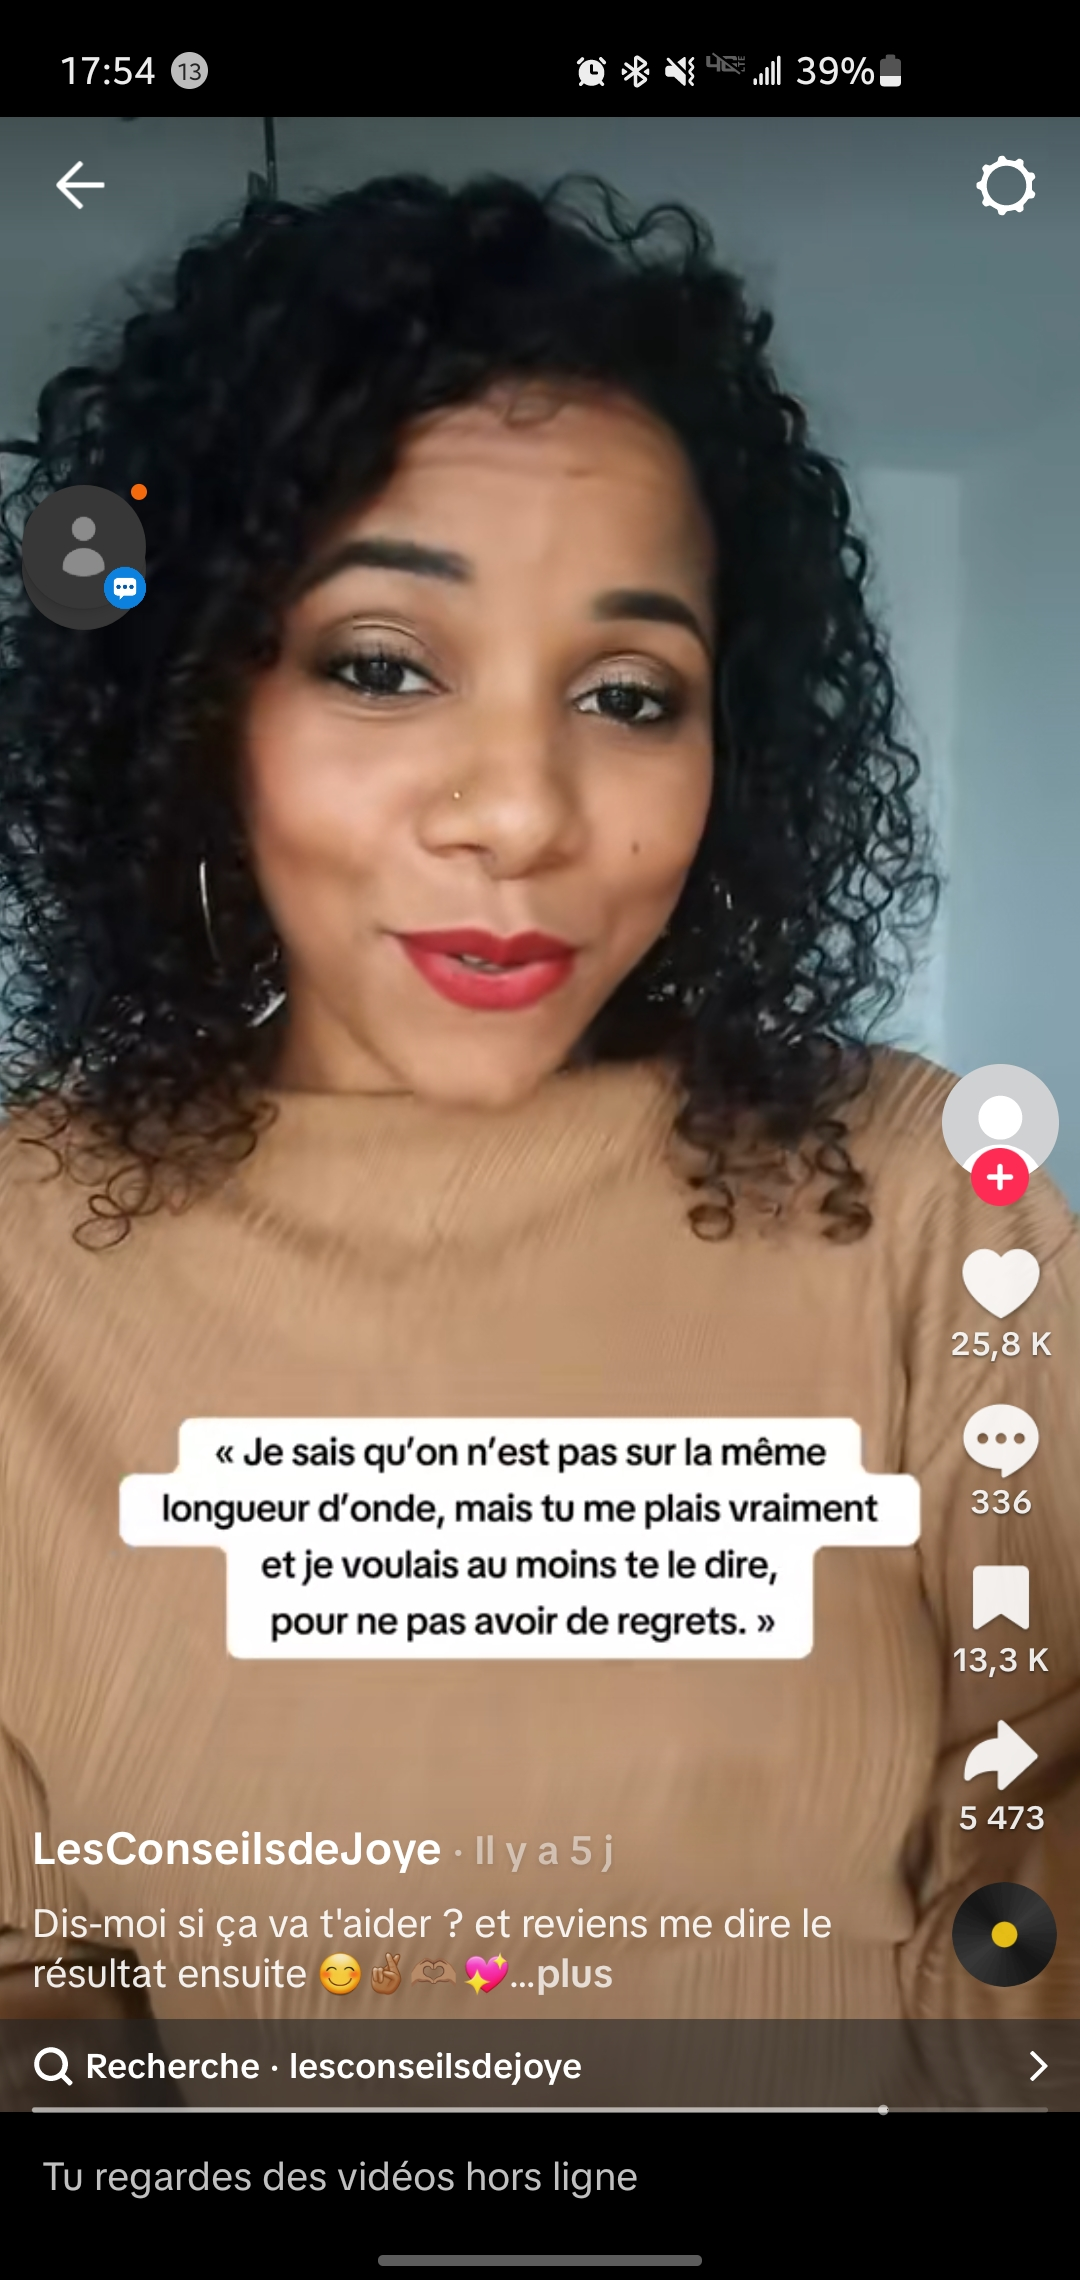

True

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("image_01.jpg")
# cv2.namedWindow("Image") # Not needed with cv2_imshow
cv2_imshow(img) # Display the image
# cv2.moveWindow("Image", 0, 0) # Not needed with cv2_imshow
# cv2.waitKey(0) # Not needed with cv2_imshow
cv2.imwrite("image_01_opencv.jpg", img) # Store on disk
# cv2.destroyAllWindows() # Not needed with cv2_imshow

In [7]:
!pip install mediapipe

import cv2
import mediapipe as mp
import os
import time
# from gpiozero import Button as GPIOButton # Commenté car non compatible avec Colab directement

# La classe a été renommée et modifiée pour fonctionner dans Google Colab sans interface graphique.
class PhotomatonExpertColab:
    def __init__(self):
        # --- Configuration Matérielle ---
        self.cap = cv2.VideoCapture(0) # 0 pour la caméra par défaut
        if not self.cap.isOpened():
            print("Erreur: Impossible d'ouvrir la caméra. Veuillez vous assurer qu'une caméra est disponible et que les permissions sont accordées.")
            # Tente d'ouvrir une autre caméra si la première échoue (parfois nécessaire en fonction du système)
            self.cap = cv2.VideoCapture(1)
            if not self.cap.isOpened():
                print("Erreur: Impossible d'ouvrir la caméra 0 ou 1. La capture vidéo ne sera pas disponible.")
                self.cap = None

        if self.cap:
            self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
            self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

        # Initialisation du bouton physique sur GPIO 18 (désactivé pour Colab)
        # try:
        #     self.physical_button = GPIOButton(18, pull_up=True)
        #     self.physical_button.when_pressed = self.capture
        #     print("Système GPIO : Prêt sur la broche 18.")
        # except Exception as e:
        #     print(f"Erreur GPIO (Normal si hors-Pi) : {e}")

        # --- Paramètres IA ---
        self.mode_ia = True
        self.current_frame = None # Stocke la dernière frame traitée
        self.mp_face_mesh = mp.solutions.face_mesh
        self.face_mesh = self.mp_face_mesh.FaceMesh(
            static_image_mode=False, max_num_faces=1, refine_landmarks=True)

        # Charge de l'asset lunettes
        glasses_path = 'assets/glasses.png'
        if not os.path.exists(glasses_path):
            print(f"AVERTISSEMENT: {glasses_path} non trouvé. L'overlay des lunettes ne fonctionnera pas. Assurez-vous de le télécharger ou de le créer.")
            self.glasses_img = None
        else:
            self.glasses_img = cv2.imread(glasses_path, cv2.IMREAD_UNCHANGED)


    def overlay_transparent(self, background, overlay, x, y):
        """Alpha Blending rigoureux pour assets PNG"""
        if overlay is None:
            return background

        bh, bw = background.shape[:2]
        oh, ow = overlay.shape[:2]

        # Retourne le fond si l'overlay est complètement hors limites
        if x + ow <= 0 or y + oh <= 0 or x >= bw or y >= bh: return background

        # Ajuste les coordonnées pour la partie visible de l'overlay
        x1, y1 = max(0, x), max(0, y)
        x2, y2 = min(bw, x + ow), min(bh, y + oh)

        # Calcule les coordonnées correspondantes dans l'image d'overlay
        ox1, oy1 = x1 - x, y1 - y
        ox2, oy2 = ow - (x + ow - x2), oh - (y + oh - y2)

        overlay_img = overlay[oy1:oy2, ox1:ox2, :3]
        mask = overlay[oy1:oy2, ox1:ox2, 3] / 255.0  # Normalisation de l'alpha

        for c in range(3):
            background[y1:y2, x1:x2, c] = (1.0 - mask) * background[y1:y2, x1:x2, c] + mask * overlay_img[:, :, c]
        return background

    def process_ai_optimized(self, frame):
        """Application de l'IA (Mediapipe) pour l'overlay"""
        h, w, _ = frame.shape
        # 1. Downsampling pour l'analyse IA
        small_frame = cv2.resize(frame, (320, 240))
        rgb_small = cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB)

        results = self.face_mesh.process(rgb_small)

        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                # 2. Mapping Inverse pour l'affichage HD
                lx = int(face_landmarks.landmark[33].x * w)
                ly = int(face_landmarks.landmark[33].y * h)
                rx = int(face_landmarks.landmark[263].x * w)

                if self.glasses_img is not None:
                    gw = int((rx - lx) * 2.2) # Facteur d'échelle lunettes
                    gh = int(gw * (self.glasses_img.shape[0] / self.glasses_img.shape[1]))

                    if gw > 0 and gh > 0:
                        overlay = cv2.resize(self.glasses_img, (gw, gh), interpolation=cv2.INTER_AREA)
                        # 3. Alpha Blending sur la frame originale
                        frame = self.overlay_transparent(frame, overlay, lx - int(gw*0.25), ly - int(gh*0.5))
        return frame

    def get_and_process_frame(self):
        """Capture et traite une seule frame vidéo, la stocke et la retourne."""
        if self.cap is None or not self.cap.isOpened():
            return None # Retourne None si la caméra n'est pas ouverte

        ret, frame = self.cap.read()
        if ret:
            frame = cv2.flip(frame, 1) # Effet miroir
            if self.mode_ia:
                frame = self.process_ai_optimized(frame)
            self.current_frame = frame
            return frame
        return None

    def capture(self):
        """Capture la photo actuelle, la sauvegarde et liste les photos existantes."""
        if self.current_frame is None:
            print("Aucune image à capturer. Assurez-vous que la caméra est active et qu'une image a été traitée.")
            return None

        print("Capture détectée !")
        timestamp = int(time.time())
        captures_dir = "captures"
        if not os.path.exists(captures_dir):
            os.makedirs(captures_dir)

        path = f"{captures_dir}/photo_{timestamp}.jpg"
        cv2.imwrite(path, self.current_frame)
        print(f"Photo sauvegardée sous : {path}")

        print("\nPhotos capturées :")
        for filename in sorted(os.listdir(captures_dir)):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                print(f"- {filename}")
        return path # Retourne le chemin de l'image capturée

    def release_camera(self):
        """Libère la ressource caméra."""
        if self.cap and self.cap.isOpened():
            self.cap.release()
            print("Caméra libérée.")

# Suppression de l'exécution Tkinter originale pour Colab
# if __name__ == "__main__":
#     root = tk.Tk()
#     app = PhotomatonExpert(root)
#     root.mainloop()

In [8]:
# Importez cv2_imshow si ce n'est pas déjà fait
from google.colab.patches import cv2_imshow
import time

# Créez une instance de la classe PhotomatonExpertColab
photomaton = PhotomatonExpertColab()

# Vérifiez si la caméra est ouverte avant de procéder
if photomaton.cap and photomaton.cap.isOpened():
    print("Caméra ouverte. Acquisition d'une image...")
    # Capturez et traitez une seule image
    frame = photomaton.get_and_process_frame()

    if frame is not None:
        print("Image traitée. Affichage...")
        # Affichez l'image dans Colab
        cv2_imshow(frame)

        # Sauvegardez l'image (cela l'ajoutera au dossier 'captures')
        photomaton.capture()
    else:
        print("Impossible d'obtenir une image de la caméra.")
else:
    print("La caméra n'est pas disponible ou n'a pas pu être ouverte.")

# Libérez les ressources de la caméra après utilisation
photomaton.release_camera()


Erreur: Impossible d'ouvrir la caméra. Veuillez vous assurer qu'une caméra est disponible et que les permissions sont accordées.
Erreur: Impossible d'ouvrir la caméra 0 ou 1. La capture vidéo ne sera pas disponible.


AttributeError: module 'mediapipe' has no attribute 'solutions'

In [9]:
import cv2
import tkinter as tk
from tkinter import messagebox
from PIL import Image, ImageTk
import os

class PhotomatonApp:
    def __init__(self, window, window_title):
        self.window = window
        self.window.title(window_title)
        self.window.attributes('-fullscreen', True) # Mode plein écran pour la borne

        # Initialisation de la caméra (0 est l'index par défaut)
        self.video_capture = cv2.VideoCapture(0)

        # Définition de la résolution (ajuster selon la caméra)
        self.video_capture.set(cv2.CAP_PROP_FRAME_WIDTH, 800)
        self.video_capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

        # --- Interface Graphique (UI) ---
        self.canvas = tk.Canvas(window, width=800, height=480)
        self.canvas.pack(pady=20)

        self.btn_frame = tk.Frame(window)
        self.btn_frame.pack(fill="both", expand=True)

        self.btn_capture = tk.Button(self.btn_frame, text="PRENDRE UNE PHOTO",
                                     command=self.capture_photo, font=("Arial", 20),
                                     bg="#2ecc71", fg="white", height=2)
        self.btn_capture.pack(side="left", expand=True, fill="both", padx=10)

        self.btn_quit = tk.Button(self.btn_frame, text="QUITTER",
                                  command=self.quit_app, font=("Arial", 20),
                                  bg="#e74c3c", fg="white", height=2)
        self.btn_quit.pack(side="right", expand=True, fill="both", padx=10)

        # Variables d'état
        self.current_frame = None
        self.update_frame() # Lancement de la boucle de rafraîchissement

        self.window.mainloop()

    def update_frame(self):
        # Lecture d'une image depuis la caméra
        ret, frame = self.video_capture.read()
        if ret:
            self.current_frame = cv2.flip(frame, 1) # Effet miroir pour l'utilisateur

            # Conversion OpenCV (BGR) vers Tkinter (RGB)
            cv2image = cv2.cvtColor(self.current_frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(cv2image)
            imgtk = ImageTk.PhotoImage(image=img)

            self.canvas.create_image(0, 0, anchor=tk.NW, image=imgtk)
            self.canvas.image = imgtk # Garder une référence pour éviter le garbage collector

        # Rappel de la fonction toutes les 15ms (~60 FPS)
        self.window.after(15, self.update_frame)

    def capture_photo(self):
        if self.current_frame is not None:
            # Sauvegarde temporaire pour le traitement futur
            if not os.path.exists("captures"):
                os.makedirs("captures")

            filename = "captures/temp_photo.jpg"
            cv2.imwrite(filename, self.current_frame)

            # Ici, on pourra appeler la fenêtre de prévisualisation et filtres
            messagebox.showinfo("Succès", "Photo capturée ! Passage aux filtres...")
            # self.open_filter_menu(filename)

    def quit_app(self):
        self.video_capture.release()
        self.window.destroy()

# Lancement de l'application
if __name__ == "__main__":
    PhotomatonApp(tk.Tk(), "Photomaton GEII - Raspberry Pi")

TclError: no display name and no $DISPLAY environment variable